In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


def get_true_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

In [37]:
data_pre =pd.read_csv('../input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')
data_pre

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,039Y,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,029Y,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,042Y,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,030Y,F,PA,2048,2500,0.168,0.168,NaN


In [38]:
# data = data_pre.loc[data_pre['View Position']=='PA']

In [39]:
data = data_pre
data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,039Y,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,029Y,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,042Y,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,030Y,F,PA,2048,2500,0.168,0.168,NaN


In [40]:
# define dummy labels for one hot encoding - simplifying to 14 primary classes (excl. No Finding)
dummy_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia','No Finding'] # taken from paper

# One Hot Encoding of Finding Labels to dummy_labels

for label in dummy_labels:
    data[label] = data['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
data.head(20) # check the data, looking good!

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No Finding
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,00000003_001.png,Hernia,1,3,074Y,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,00000003_002.png,Hernia,2,3,075Y,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,076Y,F,PA,2698,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,00000003_004.png,Hernia,4,3,077Y,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,00000003_005.png,Hernia,5,3,078Y,F,PA,2686,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


No Finding            60412.0
Infiltration          19870.0
Effusion              13307.0
Atelectasis           11535.0
Nodule                 6323.0
Mass                   5746.0
Pneumothorax           5298.0
Consolidation          4667.0
Pleural_Thickening     3385.0
Cardiomegaly           2772.0
Emphysema              2516.0
Edema                  2303.0
Fibrosis               1686.0
Pneumonia              1353.0
Hernia                  227.0
dtype: float64


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcf8b15de90>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
  <a list of 15 Text xticklabel objects>))

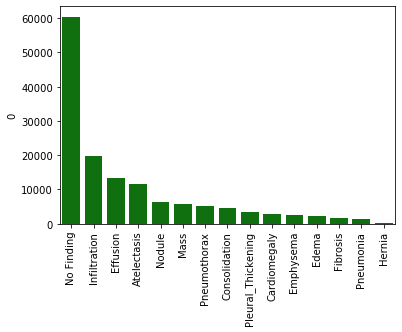

In [41]:
# now, let's see how many cases present for each of of our 14 clean classes (which excl. 'No Finding')
clean_labels = data[dummy_labels].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [42]:
# split the data into a training and testing set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 1993)

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train_set, test_size = 0.1, random_state = 1993)

# pp, test_set = train_test_split(test_set, test_size = 0.0002, random_state = 1993)

# quick check to see that the training and test set were split properly
print('training set - # of observations: ', len(train_set))
print('test set - # of observations): ', len(test_set))
print('val set - # of observations): ', len(val_set))
# print('predict set - # of observations): ', len(pp))
print('prior, full data set - # of observations): ', len(data))

training set - # of observations:  80726
test set - # of observations):  22424
val set - # of observations):  8970
prior, full data set - # of observations):  112120


In [43]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
            
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            color_mode='rgb',
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [44]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        color_mode='rgb',
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

   # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            color_mode='rgb',
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            color_mode='rgb',
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
           # class_dictionary = test_generator.class_indices,
            target_size=(target_w,target_h))
    return  valid_generator,test_generator

In [45]:
IMAGE_DIR = "../input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/"
#def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

train_generator = get_train_generator(train_set, IMAGE_DIR, "Image Index", dummy_labels)
valid_generator,test_generator= get_test_and_valid_generator(val_set,test_set, train_set, IMAGE_DIR, "Image Index", dummy_labels)

getting train generator...
Found 80726 validated image filenames.
getting train and valid generators...
Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.


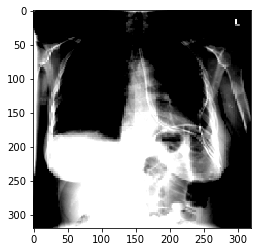

In [46]:
x, y = train_generator.__getitem__(5)
plt.imshow(x[0]);
# y[].shape

In [47]:
def compute_class_freqs(labels):
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = np.size(labels,0)

    
    positive_frequencies = labels.sum(axis=0)/N
    negative_frequencies = 1-((labels.sum(axis=0))/N)

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [48]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.10313901, 0.0416966 , 0.17813344, 0.04719669, 0.02105889,
       0.02273121, 0.01507569, 0.11883408, 0.0117682 , 0.03023809,
       0.02461413, 0.05700766, 0.05103684, 0.00203156, 0.53781929])

In [49]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

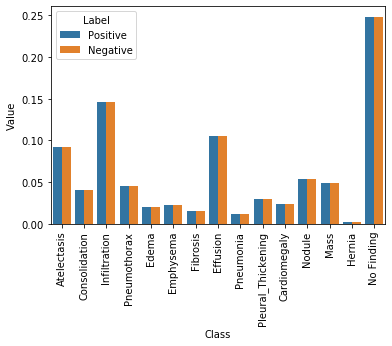

In [50]:
data = pd.DataFrame({"Class": dummy_labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": dummy_labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [51]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
          #  loss +=  -1 * np.sum(pos_weights * y_true * np.log(y_pred))  -1 * np.sum(neg_weights * (1 - y_true) * np.log(1 - y_pred)) #complete this line
            loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
        return loss

        ### END CODE HERE ###
    return weighted_loss

In [52]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_model = MobileNet(#weights='imagenet', 
                       include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(dummy_labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step


Epoch 1/256
100/100 [==============================] - 16s 159ms/step - loss: 1.1176 - val_loss: 0.9591
Epoch 2/256
100/100 [==============================] - 16s 157ms/step - loss: 1.1836 - val_loss: 1.6353
Epoch 3/256
100/100 [==============================] - 15s 155ms/step - loss: 1.1481 - val_loss: 1.5013
Epoch 4/256
100/100 [==============================] - 17s 165ms/step - loss: 1.1648 - val_loss: 1.2774
Epoch 5/256
100/100 [==============================] - 16s 156ms/step - loss: 1.1629 - val_loss: 0.9412
Epoch 6/256
100/100 [==============================] - 16s 158ms/step - loss: 1.1628 - val_loss: 1.4231
Epoch 7/256
100/100 [==============================] - 15s 154ms/step - loss: 1.1683 - val_loss: 1.2552
Epoch 8/256
100/100 [==============================] - 17s 166ms/step - loss: 1.1599 - val_loss: 0.9574
Epoch 9/256
100/100 [==============================] - 15s 155ms/step - loss: 1.1250 - val_loss: 1.2673
Epoch 10/256
100/100 [==============================] - 16s 158m

100/100 [==============================] - 16s 157ms/step - loss: 1.0920 - val_loss: 0.6348
Epoch 80/256
100/100 [==============================] - 16s 161ms/step - loss: 1.0498 - val_loss: 0.6422
Epoch 81/256
100/100 [==============================] - 16s 158ms/step - loss: 1.0736 - val_loss: 0.7694
Epoch 82/256
100/100 [==============================] - 15s 153ms/step - loss: 1.0753 - val_loss: 0.8526
Epoch 83/256
100/100 [==============================] - 16s 159ms/step - loss: 1.0620 - val_loss: 1.1189
Epoch 84/256
100/100 [==============================] - 16s 156ms/step - loss: 1.1014 - val_loss: 1.1330
Epoch 85/256
100/100 [==============================] - 16s 155ms/step - loss: 1.0846 - val_loss: 0.9858
Epoch 86/256
100/100 [==============================] - 15s 153ms/step - loss: 1.0980 - val_loss: 1.2343
Epoch 87/256
100/100 [==============================] - 16s 159ms/step - loss: 1.0261 - val_loss: 0.9930
Epoch 88/256
100/100 [==============================] - 16s 158ms/st

100/100 [==============================] - 16s 157ms/step - loss: 1.0353 - val_loss: 0.7523
Epoch 157/256
100/100 [==============================] - 16s 156ms/step - loss: 1.0634 - val_loss: 1.4093
Epoch 158/256
100/100 [==============================] - 16s 157ms/step - loss: 1.0159 - val_loss: 1.0812
Epoch 159/256
100/100 [==============================] - 16s 161ms/step - loss: 1.0124 - val_loss: 0.9307
Epoch 160/256
100/100 [==============================] - 16s 156ms/step - loss: 1.0217 - val_loss: 1.0454
Epoch 161/256
100/100 [==============================] - 16s 156ms/step - loss: 1.0266 - val_loss: 1.0958
Epoch 162/256
100/100 [==============================] - 16s 157ms/step - loss: 1.0603 - val_loss: 1.1502
Epoch 163/256
100/100 [==============================] - 16s 162ms/step - loss: 1.0651 - val_loss: 0.8405
Epoch 164/256
100/100 [==============================] - 16s 157ms/step - loss: 1.0527 - val_loss: 0.5751
Epoch 165/256
100/100 [==============================] - 16s

100/100 [==============================] - 16s 159ms/step - loss: 1.0188 - val_loss: 1.0020
Epoch 234/256
100/100 [==============================] - 16s 155ms/step - loss: 0.9997 - val_loss: 1.2513
Epoch 235/256
100/100 [==============================] - 16s 163ms/step - loss: 1.0114 - val_loss: 0.7602
Epoch 236/256
100/100 [==============================] - 16s 157ms/step - loss: 0.9807 - val_loss: 1.0498
Epoch 237/256
100/100 [==============================] - 16s 159ms/step - loss: 1.0156 - val_loss: 0.9967
Epoch 238/256
100/100 [==============================] - 15s 155ms/step - loss: 1.0642 - val_loss: 1.3495
Epoch 239/256
100/100 [==============================] - 16s 162ms/step - loss: 0.9945 - val_loss: 0.8521
Epoch 240/256
100/100 [==============================] - 16s 157ms/step - loss: 1.0384 - val_loss: 0.9544
Epoch 241/256
100/100 [==============================] - 16s 157ms/step - loss: 1.0138 - val_loss: 1.2281
Epoch 242/256
100/100 [==============================] - 16s

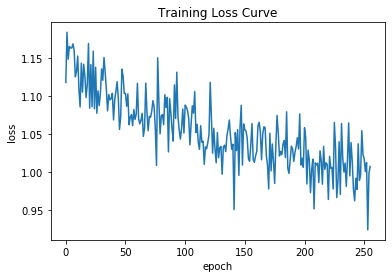

In [81]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 256)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

# plt.plot(history.history['acc'])
# plt.ylabel("acc")
# plt.xlabel("epoch")
# plt.title("Training acc Curve")
# plt.show()

In [82]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [83]:
test_generator.labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [84]:
predicted_vals

array([[0.5595037 , 0.17834485, 0.45845625, ..., 0.17441095, 0.37146312,
        0.61430025],
       [0.0280999 , 0.04268103, 0.2660389 , ..., 0.04025725, 0.04281629,
        0.8663618 ],
       [0.43476444, 0.5632909 , 0.5361985 , ..., 0.77518296, 0.42949456,
        0.34460828],
       ...,
       [0.91562337, 0.5293207 , 0.6356874 , ..., 0.23482274, 0.5118665 ,
        0.14744508],
       [0.24288903, 0.07194118, 0.5651108 , ..., 0.0706168 , 0.25985393,
        0.6371948 ],
       [0.18450046, 0.13693002, 0.41002148, ..., 0.14311893, 0.23412754,
        0.7193187 ]], dtype=float32)

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

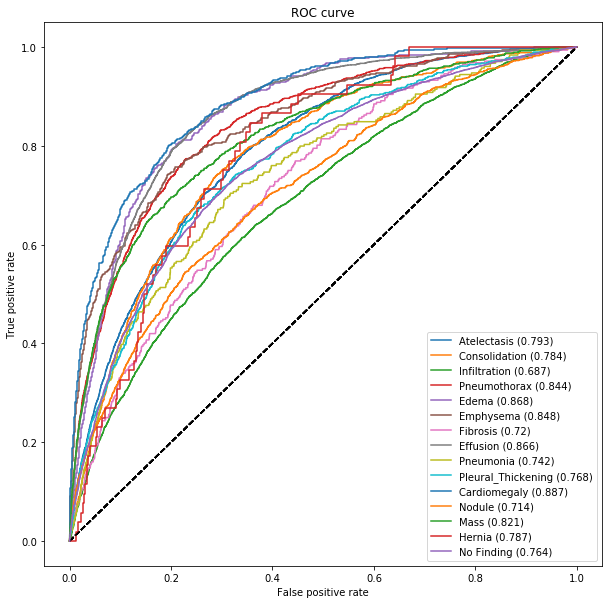

In [86]:
auc_rocs = get_roc_curve(dummy_labels, predicted_vals, test_generator)

In [87]:
pred_labels = [l + "_pred" for l in dummy_labels]
pred_labels

['Atelectasis_pred',
 'Consolidation_pred',
 'Infiltration_pred',
 'Pneumothorax_pred',
 'Edema_pred',
 'Emphysema_pred',
 'Fibrosis_pred',
 'Effusion_pred',
 'Pneumonia_pred',
 'Pleural_Thickening_pred',
 'Cardiomegaly_pred',
 'Nodule_pred',
 'Mass_pred',
 'Hernia_pred',
 'No Finding_pred']

In [88]:

# for i in pred_labels:
#     test_set[i]=""


In [89]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [90]:
np.savetxt('np.csv', predicted_vals, delimiter=',', 
           header='Atelectasis_pred,Consolidation_pred,Infiltration_pred,Pneumothorax_pred,Edema_pred,Emphysema_pred,Fibrosis_pred,Effusion_pred,Pneumonia_pred,Pleural_Thickening_pred,Cardiomegaly_pred,Nodule_pred,Mass_pred,Hernia_pred,No Finding_pred')


In [91]:
cs=pd.read_csv('np.csv')
cs

,# Atelectasis_pred,Consolidation_pred,Infiltration_pred,Pneumothorax_pred,Edema_pred,Emphysema_pred,Fibrosis_pred,Effusion_pred,Pneumonia_pred,Pleural_Thickening_pred,Cardiomegaly_pred,Nodule_pred,Mass_pred,Hernia_pred,No Finding_pred
0,0.559504,0.178345,0.458456,0.205174,0.075818,0.239325,0.412708,0.167016,0.221909,0.331745,0.118156,0.429556,0.174411,0.371463,0.614300
1,0.028100,0.042681,0.266039,0.095732,0.002030,0.019867,0.170036,0.016834,0.027395,0.138832,0.036920,0.176950,0.040257,0.042816,0.866362
2,0.434764,0.563291,0.536198,0.722576,0.284475,0.548160,0.555114,0.485934,0.434546,0.650386,0.212073,0.617161,0.775183,0.429495,0.344608
3,0.798978,0.763590,0.640532,0.155448,0.617445,0.190528,0.093476,0.948681,0.520175,0.303959,0.914581,0.179501,0.210064,0.165406,0.181047
4,0.423638,0.619026,0.533490,0.233039,0.234104,0.170723,0.441553,0.281395,0.430864,0.493631,0.284105,0.976199,0.993313,0.560742,0.119516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22419,0.091909,0.050809,0.429076,0.059290,0.008360,0.028932,0.241170,0.096306,0.067227,0.243778,0.494995,0.293780,0.039488,0.106783,0.736102
22420,0.094952,0.082158,0.362502,0.115711,0.007594,0.047097,0.321125,0.039233,0.079094,0.236213,0.124863,0.346707,0.084721,0.147900,0.771054
22421,0.915623,0.529321,0.635687,0.382464,0.211601,0.340032,0.427492,0.940378,0.525535,0.548116,0.826292,0.360158,0.234823,0.511867,0.147445
22422,0.242889,0.071941,0.565111,0.153375,0.006195,0.065276,0.322932,0.073471,0.107889,0.305179,0.055913,0.400396,0.070617,0.259854,0.637195


In [92]:
cs = cs.rename(columns={'# Atelectasis_pred': 'Atelectasis_pred'})


In [93]:
cs['Image Index'] = test_generator.filenames
cs

,Atelectasis_pred,Consolidation_pred,Infiltration_pred,Pneumothorax_pred,Edema_pred,Emphysema_pred,Fibrosis_pred,Effusion_pred,Pneumonia_pred,Pleural_Thickening_pred,Cardiomegaly_pred,Nodule_pred,Mass_pred,Hernia_pred,No Finding_pred,Image Index
0,0.559504,0.178345,0.458456,0.205174,0.075818,0.239325,0.412708,0.167016,0.221909,0.331745,0.118156,0.429556,0.174411,0.371463,0.614300,00000538_003.png
1,0.028100,0.042681,0.266039,0.095732,0.002030,0.019867,0.170036,0.016834,0.027395,0.138832,0.036920,0.176950,0.040257,0.042816,0.866362,00025917_001.png
2,0.434764,0.563291,0.536198,0.722576,0.284475,0.548160,0.555114,0.485934,0.434546,0.650386,0.212073,0.617161,0.775183,0.429495,0.344608,00020405_025.png
3,0.798978,0.763590,0.640532,0.155448,0.617445,0.190528,0.093476,0.948681,0.520175,0.303959,0.914581,0.179501,0.210064,0.165406,0.181047,00011140_003.png
4,0.423638,0.619026,0.533490,0.233039,0.234104,0.170723,0.441553,0.281395,0.430864,0.493631,0.284105,0.976199,0.993313,0.560742,0.119516,00027564_006.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22419,0.091909,0.050809,0.429076,0.059290,0.008360,0.028932,0.241170,0.096306,0.067227,0.243778,0.494995,0.293780,0.039488,0.106783,0.736102,00014292_000.png
22420,0.094952,0.082158,0.362502,0.115711,0.007594,0.047097,0.321125,0.039233,0.079094,0.236213,0.124863,0.346707,0.084721,0.147900,0.771054,00014347_000.png
22421,0.915623,0.529321,0.635687,0.382464,0.211601,0.340032,0.427492,0.940378,0.525535,0.548116,0.826292,0.360158,0.234823,0.511867,0.147445,00000109_001.png
22422,0.242889,0.071941,0.565111,0.153375,0.006195,0.065276,0.322932,0.073471,0.107889,0.305179,0.055913,0.400396,0.070617,0.259854,0.637195,00018200_000.png


In [94]:
merged_test_set = pd.merge(test_set,cs)

In [95]:
merged_test_set.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No Finding,Atelectasis_pred,Consolidation_pred,Infiltration_pred,Pneumothorax_pred,Edema_pred,Emphysema_pred,Fibrosis_pred,Effusion_pred,Pneumonia_pred,Pleural_Thickening_pred,Cardiomegaly_pred,Nodule_pred,Mass_pred,Hernia_pred,No Finding_pred
0,00000538_003.png,No Finding,3,538,075Y,F,PA,2506,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.559504,0.178345,0.458456,0.205174,0.075818,0.239325,0.412708,0.167016,0.221909,0.331745,0.118156,0.429556,0.174411,0.371463,0.614300
1,00025917_001.png,No Finding,1,25917,021Y,M,PA,2938,2885,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.028100,0.042681,0.266039,0.095732,0.002030,0.019867,0.170036,0.016834,0.027395,0.138832,0.036920,0.176950,0.040257,0.042816,0.866362
2,00020405_025.png,No Finding,25,20405,049Y,M,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.434764,0.563291,0.536198,0.722576,0.284475,0.548160,0.555114,0.485934,0.434546,0.650386,0.212073,0.617161,0.775183,0.429495,0.344608
3,00011140_003.png,Effusion|Infiltration,3,11140,040Y,F,AP,2500,2048,0.168,0.168,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.798978,0.763590,0.640532,0.155448,0.617445,0.190528,0.093476,0.948681,0.520175,0.303959,0.914581,0.179501,0.210064,0.165406,0.181047
4,00027564_006.png,No Finding,6,27564,050Y,M,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.423638,0.619026,0.533490,0.233039,0.234104,0.170723,0.441553,0.281395,0.430864,0.493631,0.284105,0.976199,0.993313,0.560742,0.119516


In [96]:
# get_performance_metrics(test_generator.labels, predicted_vals, dummy_labels)

In [97]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute TN
    TN = np.sum((y == 0) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    
    ### END CODE HERE ###
    
    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return FN

In [98]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_accuracy(y, pred, th=0.5):
    
    accuracy = 0.0
    
    TP =  true_positives(y, pred, th=0.5)
    FP =  false_positives(y, pred, th=0.5)
    TN =  true_negatives(y, pred, th=0.5)
    FN =  false_negatives(y, pred, th=0.5)

    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    
    return accuracy

In [99]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_prevalence(y):
    
    prevalence = 0.0
        
    prevalence = np.count_nonzero(y)/y.size
    
    
    return prevalence

In [100]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_sensitivity(y, pred, th=0.5):
   
    sensitivity = 0.0
    
    # get TP and FN using our previously defined functions
    TP = true_positives(y, pred, th=0.5)
    FN = false_negatives(y, pred, th=0.5)

    sensitivity = TP/(TP+FN)
    
    ### END CODE HERE ###
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
   
    specificity = 0.0
        
    TN =  true_negatives(y, pred, th=0.5)
    FP =  false_positives(y, pred, th=0.5)
    
    specificity = TN/(TN+FP)
    
    
    return specificity

In [101]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_ppv(y, pred, th=0.5):
    
    PPV = 0.0
    
    
    TP = true_positives(y, pred, th=0.5)
    FP = false_positives(y, pred, th=0.5)

    PPV = TP/(TP+FP)
    
    
    return PPV

def get_npv(y, pred, th=0.5):
    
    NPV = 0.0
    
    
    TN = true_negatives(y, pred, th=0.5)
    FN = false_negatives(y, pred, th=0.5)

    NPV = TN/(TN+FN)
    
    
    return NPV

In [102]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics
statistics = bootstrap_auc(test_generator.labels, predicted_vals, dummy_labels)

In [103]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
get_performance_metrics(test_generator.labels, predicted_vals, dummy_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Atelectasis,1692,13957,6182,593,0.698,0.102,0.74,0.693,0.215,0.959,0.793,0.333,0.5
Consolidation,695,15303,6179,247,0.713,0.042,0.738,0.712,0.101,0.984,0.784,0.178,0.5
Infiltration,2297,12605,5949,1573,0.665,0.173,0.594,0.679,0.279,0.889,0.687,0.379,0.5
Pneumothorax,788,16824,4552,260,0.785,0.047,0.752,0.787,0.148,0.985,0.844,0.247,0.5
Edema,354,16824,5164,82,0.766,0.019,0.812,0.765,0.064,0.995,0.868,0.119,0.5
Emphysema,349,17808,4138,129,0.81,0.021,0.73,0.811,0.078,0.993,0.848,0.141,0.5
Fibrosis,196,15059,7053,116,0.68,0.014,0.628,0.681,0.027,0.992,0.72,0.052,0.5
Effusion,2149,15334,4443,498,0.78,0.118,0.812,0.775,0.326,0.969,0.866,0.465,0.5
Pneumonia,156,17968,4152,148,0.808,0.014,0.513,0.812,0.036,0.992,0.742,0.068,0.5


In [104]:
print_confidence_intervals(dummy_labels, statistics)

,Mean AUC (CI 5%-95%)
Atelectasis,0.79 (0.76-0.82)
Consolidation,0.78 (0.73-0.84)
Infiltration,0.69 (0.64-0.72)
Pneumothorax,0.84 (0.79-0.89)
Edema,0.86 (0.79-0.92)
Emphysema,0.85 (0.77-0.92)
Fibrosis,0.72 (0.62-0.83)
Effusion,0.86 (0.84-0.89)
Pneumonia,0.75 (0.62-0.84)
Pleural_Thickening,0.78 (0.69-0.83)


In [105]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# confusion_mtx = confusion_matrix(test_generator.labels, predicted_vals) 
# confusion_mtx

In [106]:
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(test_generator, predictions)